In [1]:
import os
import pandas as pd
import nltk
import requests
import string
from gensim.models import Word2Vec, KeyedVectors
import shutil
import numpy as np
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Attention, Concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import shap


In [2]:
FINE_TUNED_DIR = '../../pretained_or_finetune-models'
REVIEWS_DATASET_DIR = '../../dataset'
UTILS_DIR = '../../utils'
NLTK_DATA_PATH = f"{FINE_TUNED_DIR}/nltk_data"

nltk.data.path.append(NLTK_DATA_PATH)

In [3]:
tourism_reviews_en = pd.read_csv(f"{REVIEWS_DATASET_DIR}/eng_reviews_emotion_classify.csv", encoding='utf-8')

columns_to_use = ['helpful_votes', 'location_id', 'review_id', 'review',
                  'review_subject', 'trip_type', 'rating',
                  'location_name', 'province', 'place_id', 'emotion', 'cleaned_review']
columns_to_train = ['location_id', 'review', 'rating']
review_df = tourism_reviews_en[columns_to_train]

In [4]:
review_df.describe()

,location_id,rating
count,5.909000e+03,5909.000000
mean,6.483167e+06,4.153833
std,4.877561e+06,1.067077
min,3.110380e+05,1.000000
25%,2.578107e+06,4.000000
50%,6.017599e+06,4.000000
75%,8.818088e+06,5.000000
max,2.714283e+07,5.000000


In [5]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5909 entries, 0 to 5908
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   location_id  5909 non-null   int64 
 1   review       5909 non-null   object
 2   rating       5909 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 138.6+ KB


In [6]:
review_df

,location_id,review,rating
0,2209612,Besides elegant grand palace and wat pra kaew ...,5
1,2209612,This is one of the last big king temples of Ba...,4
2,2209612,"It is beautiful, clean and free to enter. Both...",4
3,2209612,Wat Ratchabophit is a Buddhist temple located ...,5
4,2209612,Wat Ratchabophit is a historic royal temple bu...,5
...,...,...,...
5904,1831068,Is quite far from Korat Town or main highway. ...,3
5905,1831068,Prasat Pueai Noi is claimed to be the biggest ...,3
5906,1831068,I think this place is claimed to be the oldest...,4
5907,1831068,The compound comprises three brick buildings o...,4


In [15]:
binary_url = 'https://github.com/BrownDSI/word2vec-slim/releases/' + \
             'download/v0.1/GoogleNews-vectors-negative300-slim.bin.gz'
r = requests.get(binary_url)
open('google-word2vec-slim.bin.gz', 'wb').write(r.content);

#Load model contrained abot 300k of vocabs
model = KeyedVectors.load_word2vec_format('google-word2vec-slim.bin.gz', binary = True)

In [7]:
print(os.path.exists(f"{NLTK_DATA_PATH}/tokenizers/punkt")) 

True


In [ ]:
# 1. Data Preparation
nltk.download ('all', download_dir=NLTK_DATA_PATH)

In [18]:
from nltk.tokenize import word_tokenize, sent_tokenize
text = "Hello Mr. Smith, how are you doing today? The weather is great and Python is awesome. The sky is pinkish-blue. You should not eat cardboard."
word_tokenize ( text )
sent_tokenize ( text )

['Hello Mr. Smith, how are you doing today?',
 'The weather is great and Python is awesome.',
 'The sky is pinkish-blue.',
 'You should not eat cardboard.']

In [8]:
from nltk.corpus import stopwords 

custom_stopwords = set(stopwords.words('english'))

In [9]:
print(nltk.data.find('tokenizers/punkt'))

/Users/ittichaiboonyarakthunya/nltk_data/tokenizers/punkt


In [9]:
from nltk.stem import WordNetLemmatizer

stop_words = custom_stopwords
lemmatizer = WordNetLemmatizer()

In [12]:
from nltk.tokenize import word_tokenize, sent_tokenize

In [13]:
def advanced_clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    text = re.sub(r'\b(u|ur|b4)\b', 'you', text)  # Replace common abbreviations
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    words = [word for word in words if word not in string.punctuation]
    return ' '.join(words)

In [14]:
# Apply preprocessing to the review texts
review_df['cleaned_review'] = review_df['review'].apply(advanced_clean_text)

# 2. สร้าง Word Embeddings ด้วย Word2Vec
# word2vec_model = Word2Vec(sentences=review_df['cleaned_review'], vector_size=300, window=5, min_count=1, sg=1)  # ใช้ Skip-Gram
sentences = [row.split() for row in review_df['cleaned_review']]
word2vec_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)  # เปลี่ยน vector_size เป็น 300



/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_8269/2616607316.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['cleaned_review'] = review_df['review'].apply(advanced_clean_text)


In [101]:
review_df.to_csv("./review_df.csv")
review_df

,location_id,review,rating,cleaned_review,embedding,sentiment
0,2209612,Besides elegant grand palace and wat pra kaew ...,5,besides elegant grand palace wat pra kaew emer...,"[[-0.028509778901934624, 0.3325634002685547, 0...",positive
1,2209612,This is one of the last big king temples of Ba...,4,one last big king temple bangkok one lot europ...,"[[-0.003996930085122585, 0.014730370603501797,...",positive
2,2209612,"It is beautiful, clean and free to enter. Both...",4,beautiful clean free enter exterior interior s...,"[[-0.028509778901934624, 0.3325634002685547, 0...",positive
3,2209612,Wat Ratchabophit is a Buddhist temple located ...,5,wat ratchabophit buddhist temple located fuean...,"[[-0.0015841611893847585, 0.034438904374837875...",positive
4,2209612,Wat Ratchabophit is a historic royal temple bu...,5,wat ratchabophit historic royal temple built k...,"[[-0.0015841611893847585, 0.034438904374837875...",positive
...,...,...,...,...,...,...
5904,1831068,Is quite far from Korat Town or main highway. ...,3,quite far korat town main highway beautiful bu...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",neutral
5905,1831068,Prasat Pueai Noi is claimed to be the biggest ...,3,prasat pueai noi claimed biggest khmer sanctua...,"[[-0.004209618084132671, 0.07795886695384979, ...",neutral
5906,1831068,I think this place is claimed to be the oldest...,4,think place claimed oldest khmerstyle ruin upp...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",positive
5907,1831068,The compound comprises three brick buildings o...,4,compound comprises three brick building lateri...,"[[-0.020202770829200745, 0.1382008045911789, 0...",positive


In [15]:
# Parameters
embedding_dim = 300  # Assuming Word2Vec has 300 dimensions
gru_units = 128
dropout_rate = 0.5
num_classes = 1  # Binary classification
max_sequence_length = 100  # Maximum length of input sequences
ngram_range = (1, 2)  # Unigrams and bigrams
max_features = 20000  

# Create the embedding matrix from the Word2Vec model
word_index = {word: i for i, word in enumerate(word2vec_model.wv.index_to_key)}
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

In [16]:
def text_to_word2vec(tokens, model, max_length=300):
    vector = np.zeros((max_length, 300))
    for i, word in enumerate(tokens):
        if i < max_length:
            if word in model.wv:
                vector[i] = model.wv[word]
    return vector

review_df['embedding'] = review_df['cleaned_review'].apply(lambda x: text_to_word2vec(x, word2vec_model))


/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_8269/1367629667.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['embedding'] = review_df['cleaned_review'].apply(lambda x: text_to_word2vec(x, word2vec_model))


In [17]:
def map_rating_to_sentiment(rating):
    if rating in [1, 2]:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:  # 4 or 5
        return 'positive'

review_df['sentiment'] = review_df['rating'].apply(map_rating_to_sentiment)

/var/folders/fk/449tdf_12hzd2r7ps4659q0m0000gn/T/ipykernel_8269/1027385966.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['sentiment'] = review_df['rating'].apply(map_rating_to_sentiment)


In [18]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(review_df['cleaned_review'])

X = tokenizer.texts_to_sequences(review_df['cleaned_review'])
X = pad_sequences(X, maxlen=max_sequence_length)

# แปลงคอลัมน์ 'sentiment' เป็นข้อมูลตัวเลข
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
y = review_df['sentiment'].map(label_mapping)

In [20]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

# แบ่งข้อมูลใหม่อีกครั้งหลังจาก SMOTE
X_train_resampled, X_val, y_train_resampled, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training+validation set into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)


In [23]:
# Check the shapes of the resulting arrays
print(f"X_train shape: {X_train_resampled.shape}")
print(f"y_train shape: {y_train_resampled.shape}")
print(f"X_test shape: {X_val.shape}")
print(f"y_test shape: {y_val.shape}")


X_train shape: (11253, 100)
y_train shape: (11253,)
X_test shape: (2814, 100)
y_test shape: (2814,)


In [24]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Step 6: Build the GRU Model
gru_units = 128
dropout_rate = 0.5
input_shape = X_train.shape[1:] 

model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    trainable=False))
model.add(GRU(units=gru_units, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(GRU(units=gru_units))
model.add(Dropout(dropout_rate))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=3, activation='softmax'))   # 3 classes: negative, neutral, positive



In [27]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if i < max_features:
        # ใช้ [] แทนการใช้ get() เพื่อดึง embedding vector
        if word in word2vec_model.wv:
            embedding_vector = word2vec_model.wv[word]
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [26]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     4,825,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,825,800 (18.41 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,825,800 (18.41 MB)

In [28]:
from sklearn.utils import resample

# Assuming `review_df` is your original DataFrame with a 'sentiment' column

# 1. Separate the data by class
df_positive = review_df[review_df.sentiment == 'positive']
df_neutral = review_df[review_df.sentiment == 'neutral']
df_negative = review_df[review_df.sentiment == 'negative']

# 2. Resample the minority classes
# For example, oversample the neutral and negative classes to match the positive class
df_neutral_upsampled = resample(df_neutral,
                                replace=True,  # Sample with replacement
                                n_samples=len(df_positive),  # Match number of positive class samples
                                random_state=42)  # Reproducible results

df_negative_upsampled = resample(df_negative,
                                 replace=True,  # Sample with replacement
                                 n_samples=len(df_positive),  # Match number of positive class samples
                                 random_state=42)  # Reproducible results

# 3. Combine the resampled DataFrames
df_balanced = pd.concat([df_positive, df_neutral_upsampled, df_negative_upsampled])

# 4. Shuffle the combined DataFrame
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# 5. Check the distribution of the classes
print(df_balanced['sentiment'].value_counts())


sentiment
neutral     4689
negative    4689
positive    4689
Name: count, dtype: int64


In [29]:
df_balanced

,location_id,review,rating,cleaned_review,embedding,sentiment
0,4322585,This was an ornate wat inside Mae Sot. It is a...,3,ornate wat inside mae sot burmese style wat ty...,"[[-0.0035578864626586437, 0.015044990926980972...",neutral
1,2667297,Got the Asia perfect for body treatment. We re...,2,got asia perfect body treatment read review th...,"[[-0.0019108267733827233, 0.03992197662591934,...",negative
2,10388576,A few years ago a huge market was built in Ban...,4,year ago huge market built ban phe totally dis...,"[[-0.0008210642845369875, 0.014425912871956825...",positive
3,6885224,The visit to this island is worth it just to u...,1,visit island worth understand tragic result un...,"[[-0.04817798733711243, 0.2319755256175995, 0....",negative
4,6669325,So many different bananas! And a chance to see...,5,many different banana chance see stored taste ...,"[[-0.0015558315208181739, 0.019142841920256615...",positive
...,...,...,...,...,...,...
14062,7287889,It is not as pretty as some picture lead to be...,3,pretty picture lead believe big either minute ...,"[[-0.004027116112411022, 0.08379366248846054, ...",neutral
14063,10631803,The whole trip was spoilt by lying local tour ...,1,whole trip spoilt lying local tour package sel...,"[[-0.0017780406633391976, 0.03009865991771221,...",negative
14064,1368429,"As a keen biker, I was excited to experience t...",3,keen biker excited experience breathtaking sce...,"[[-0.004227908793836832, 0.06994619220495224, ...",neutral
14065,8300428,This place is really beautiful and was decorat...,5,place really beautiful decorated statue maenak...,"[[-0.004027116112411022, 0.08379366248846054, ...",positive


In [33]:
from sklearn.utils.class_weight import compute_class_weight

unique_classes = np.unique(y_train)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Optional: Normalize class weights
total = sum(class_weights_dict.values())
class_weights_dict = {k: v / total for k, v in class_weights_dict.items()}

In [34]:
class_weights_dict = dict(enumerate(class_weights))

In [35]:
class_weights_dict

{0: 4.190602836879433, 1: 2.643736017897092, 2: 0.419618286728806}

In [31]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# กำหนดการตั้งค่า Early Stopping และ Model Checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('../../models/GRU_models_sample.keras', monitor='val_loss', save_best_only=True)  # เปลี่ยนจาก .h5 เป็น .keras

# ฝึกโมเดล
history = model.fit(X_train_resampled, y_train_resampled,
                    epochs=30,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint],
                    class_weight=None)


Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.3228 - loss: 1.0986 - val_accuracy: 0.3170 - val_loss: 1.0988
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.3362 - loss: 1.0986 - val_accuracy: 0.3170 - val_loss: 1.0989
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.3379 - loss: 1.0986 - val_accuracy: 0.3170 - val_loss: 1.0991
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 114ms/step - accuracy: 0.3397 - loss: 1.0986 - val_accuracy: 0.3170 - val_loss: 1.0989
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 111ms/step - accuracy: 0.3354 - loss: 1.0986 - val_accuracy: 0.3170 - val_loss: 1.0990
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 111ms/step - accuracy: 0.3353 - loss: 1.0986 - val_accuracy: 0.3170 - val_loss: 1.0990


In [38]:
# Step 8: Train the Model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    class_weight=class_weights_dict)


KeyError: 8

In [36]:
# 1. Evaluate the Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# 2. Make Predictions
y_pred_prob = model.predict(X_test)

# If your output layer is using 'softmax', y_pred_prob will be probabilities for each class.
# To get the predicted class labels, you can use np.argmax:
y_pred_class = np.argmax(y_pred_prob, axis=1)

# 3. Compare the predicted labels with the true labels
print(f'Predicted classes: {y_pred_class[:20]}')  # Display the first 10 predictions
print(f'True classes: {y_test[:20]}')  

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1344 - loss: 1.1007
Test Loss: 1.1007
Test Accuracy: 0.1328
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Predicted classes: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
True classes: 3489    0
4909    2
1425    2
4743    1
439     2
5490    2
1319    2
1330    2
4091    2
296     2
5368    2
3458    2
2801    2
2299    2
787     2
5573    2
2778    2
4703    1
5609    1
3841    2
Name: sentiment, dtype: int64


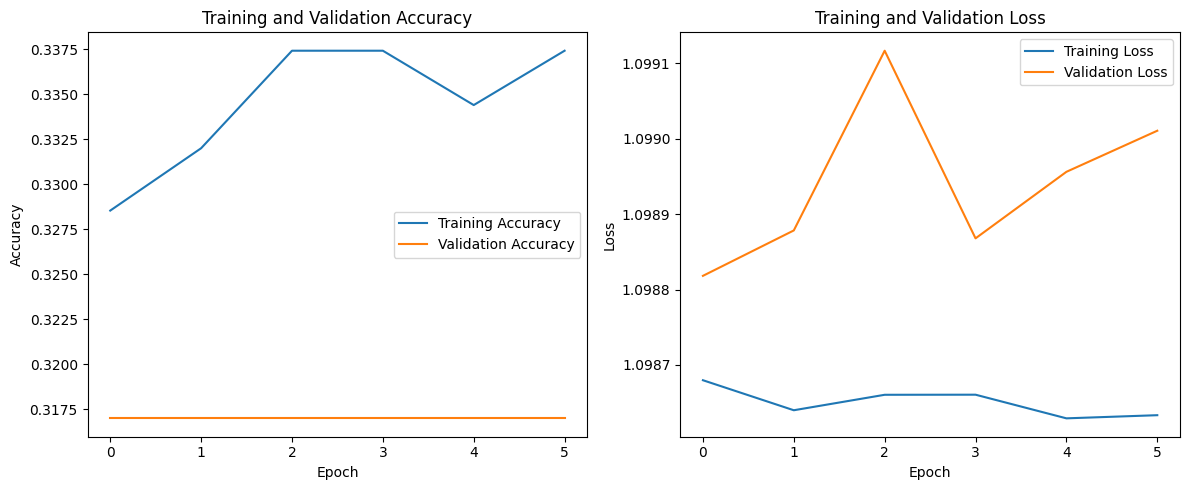

In [37]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']      # Training accuracy
val_acc = history.history['val_accuracy']  # Validation accuracy
loss = history.history['loss']         # Training loss
val_loss = history.history['val_loss']  # Validation loss

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # Create subplot for accuracy
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)  # Create subplot for loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [153]:


# predictions_df = pd.DataFrame(data=y_pred_class, index=y_test.index, columns=['predicted_sentiment'])

# review_df.loc[y_test.index, 'predicted_sentiment'] = predictions_df['predicted_sentiment']


In [161]:

predictions_df = pd.DataFrame({
    'review_text': review_df.loc[y_test.index, 'review'],  # Assuming X_test is a subset with a specific index
    'actual_sentiment': y_test,  # The actual sentiment labels
    'predicted_sentiment': y_pred_class  # The predicted sentiment labels
})

predictions_df['actual_sentiment'] = predictions_df['actual_sentiment'].map(label_mapping)
predictions_df['predicted_sentiment'] = predictions_df['predicted_sentiment'].map(label_mapping)

predictions_df.head(5)


,review_text,actual_sentiment,predicted_sentiment
3489,While I should probably come back at a better ...,negative,positive
4909,Nice place Have Food Court KFC Lawson Bic C Se...,positive,positive
1425,Since I was born and grew up in Ceylon (Sri La...,positive,positive
4743,This shrine is located in front of Central\nWo...,neutral,positive
439,Wat Suan Dok is just east of the Old City on S...,positive,positive


In [162]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_class)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7902


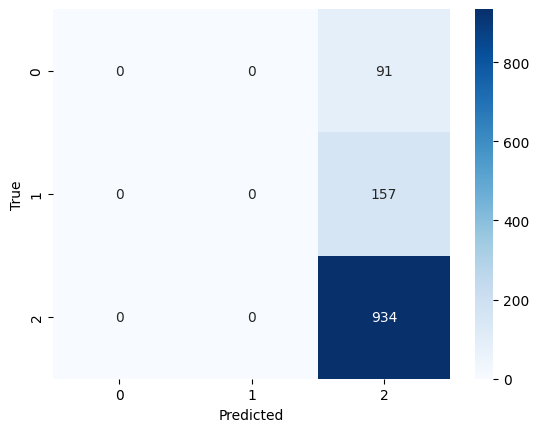

In [135]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [137]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_class, target_names=['negative', 'neutral', 'positive']))


              precision    recall  f1-score   support

    negative       0.00      0.00      0.00        91
     neutral       0.00      0.00      0.00       157
    positive       0.79      1.00      0.88       934

    accuracy                           0.79      1182
   macro avg       0.26      0.33      0.29      1182
weighted avg       0.62      0.79      0.70      1182



/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python

In [163]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred_class, average='weighted')
recall = recall_score(y_test, y_pred_class, average='weighted')
f1 = f1_score(y_test, y_pred_class, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Precision: 0.6244
Recall: 0.7902
F1-Score: 0.6976


/Users/ittichaiboonyarakthunya/Library/Caches/pypoetry/virtualenvs/is-project-thailand-tourism-recommendation-qwL-LsgH-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [167]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Assume y_test contains true class labels, and y_pred_prob contains predicted probabilities

# Binarize the output labels for calculating AUC
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Assuming 3 classes: 0, 1, 2

# Calculate the AUC for each class
auc_macro = roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr')
auc_micro = roc_auc_score(y_test_bin, y_pred_prob, average='micro', multi_class='ovr')

print(f'Macro-Averaged AUC: {auc_macro:.4f}')
print(f'Micro-Averaged AUC: {auc_micro:.4f}')

Macro-Averaged AUC: 0.5000
Micro-Averaged AUC: 0.8566


In [165]:
from sklearn.metrics import log_loss

# Calculate log loss
log_loss_value = log_loss(y_test, y_pred_prob)
print(f'Log Loss: {log_loss_value:.4f}')

Log Loss: 0.7264


In [166]:
from sklearn.metrics import cohen_kappa_score

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred_class)
print(f"Cohen's Kappa: {kappa:.4f}")

Cohen's Kappa: 0.0000
